In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Function
from matplotlib import pyplot as plt
from itertools import product
from Models_and_losses import *

In [0]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [0]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
X, y = load_boston(return_X_y=True)

X = StandardScaler().fit_transform(X)

y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()

X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)

dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)

dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [0]:
n_layers = 1
TRAIN_LENGTH = int(X_train.shape[0])
regressor = Bayesian_ReLU(13, 2, n_layers).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=1e-2)
n_epochs = 100

In [0]:
train_model(regressor,n_layers,optimizer,elbo_loss,
          n_epochs,TRAIN_LENGTH,X_train, y_train)

In [0]:
mu,std = make_predictions(regressor,X_test)
mu,std = mu.detach().numpy(),std.detach().numpy()

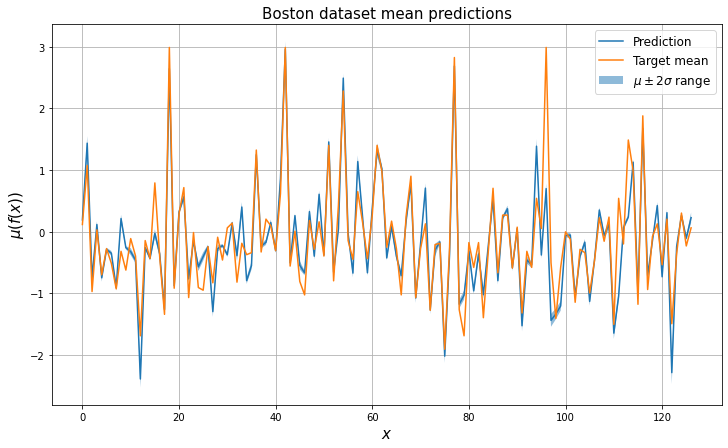

In [9]:
plot_res(y_test,std,mu,'Boston dataset')

In [0]:
def model_2d(data):
  x = data[:,0]
  y = data[:,1]
  real_labels = torch.sin(12*x*y) + 0.66*torch.cos(25*(x+y)) + torch.exp(x-y)
  return real_labels

In [0]:
x1 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)
y1 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)

x2 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)
y2 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)

# x3 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)
# y3 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)

# x4 = np.random.normal(-1/2**0.5*np.ones(100),np.ones(100)/10)
# y4 = np.random.normal(1/2**0.5*np.ones(100),np.ones(100)/10)

In [0]:
x = np.concatenate([x1,x2
                    # ,x3,x4
                    ])
y = np.concatenate([y1,y2
                    # ,y3,y4
                    ])

In [0]:
tau = 1
points = torch.Tensor(np.stack([x,y],axis=1))
target = (model_2d(points)+torch.normal(torch.zeros_like(points[:,0]),torch.ones_like(points[:,0])/np.sqrt(tau) ))[:,None]

In [0]:
grid_x = np.linspace(-2,2,200)
grid_y = np.linspace(-2,2,200)
grid = torch.Tensor(list(product(grid_x,grid_y)))
xx, yy = np.meshgrid(grid_x,grid_y)

In [0]:
TRAIN_LENGTH = target.shape[0]
n_epochs = 1000
n_layers = 1
bnn1 = Bayesian_ReLU(2, 2, n_layers).to(device)
optbnn1 = optim.Adam(bnn1.parameters(), lr=1e-2)

bnn1_var = Bayesian_ReLU(2, 2, n_layers).to(device)
optbnn1_var = optim.Adam(bnn1_var.parameters(), lr=1e-2)

mc1 = MCDO(2, 1, n_layers).to(device)
optmc1 = optim.Adam(mc1.parameters(), lr=1e-3)

In [0]:
train_model(bnn1,n_layers,optbnn1,elbo_loss,
          n_epochs,TRAIN_LENGTH,points, target,variance = 'constant')

In [0]:
mu,std = make_predictions(bnn1,grid,variance = 'constant')
mu,std = mu.detach().numpy(),std.detach().numpy()

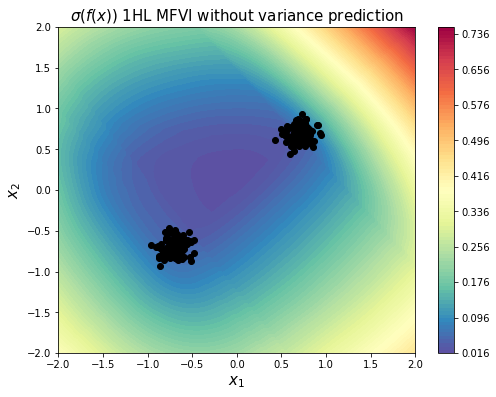

In [18]:
plot_res(xx,yy,std.reshape(200,200),
         '1HL MFVI without variance prediction',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
train_model(bnn1_var,n_layers,optbnn1_var,elbo_loss,
          n_epochs,TRAIN_LENGTH,points, target,variance = 'estimate')

In [0]:
mu,std = make_predictions(bnn1_var,grid,variance = 'estimate')
mu,std = mu.detach().numpy(),std.detach().numpy()

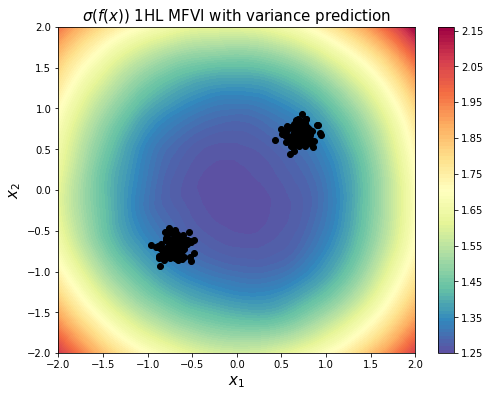

In [21]:
plot_res(xx,yy,std.reshape(200,200),
         '1HL MFVI with variance prediction',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
train_model(mc1,n_layers,optmc1,MCDO_loss,
          n_epochs,TRAIN_LENGTH,points, target)

In [0]:
mu,std = make_predictions(mc1,grid)
mu,std = mu.detach().numpy(),std.detach().numpy()

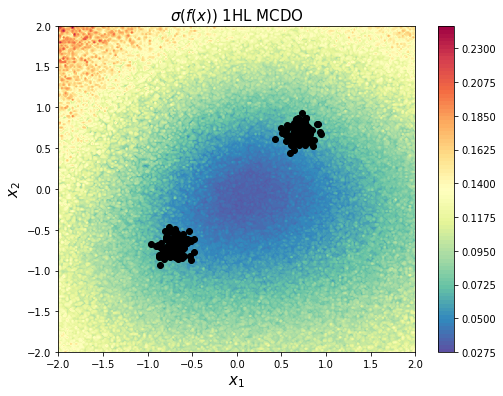

In [24]:
plot_res(xx,yy,std.reshape(200,200),
         '1HL MCDO',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
n_layers = 2
bnn2 = Bayesian_ReLU(2, 2, n_layers).to(device)
optbnn2 = optim.Adam(bnn2.parameters(), lr=1e-2)

bnn2_var = Bayesian_ReLU(2, 2, n_layers).to(device)
optbnn2_var = optim.Adam(bnn2_var.parameters(), lr=1e-2)

mc2 = MCDO(2, 1, n_layers).to(device)
optmc2 = optim.Adam(mc2.parameters(), lr=1e-3)

In [0]:
train_model(bnn2,n_layers,optbnn2,elbo_loss,
          n_epochs,TRAIN_LENGTH,points, target,variance = 'constant')

In [0]:
mu,std = make_predictions(bnn2,grid,variance = 'constant')
mu,std = mu.detach().numpy(),std.detach().numpy()

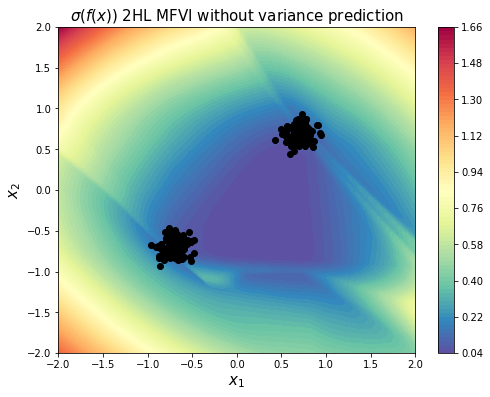

In [28]:
plot_res(xx,yy,std.reshape(200,200),
         '2HL MFVI without variance prediction',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
train_model(bnn2_var,n_layers,optbnn2_var,elbo_loss,
          n_epochs,TRAIN_LENGTH,points, target,variance = 'estimate')

In [0]:
mu,std = make_predictions(bnn2_var,grid,variance = 'estimate')
mu,std = mu.detach().numpy(),std.detach().numpy()

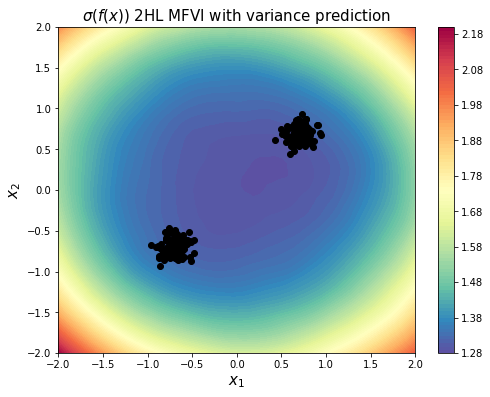

In [31]:
plot_res(xx,yy,std.reshape(200,200),
         '2HL MFVI with variance prediction',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
train_model(mc2,n_layers,optmc2,MCDO_loss,
          n_epochs,TRAIN_LENGTH,points, target)

In [0]:
mu,std = make_predictions(mc2,grid)
mu,std = mu.detach().numpy(),std.detach().numpy()

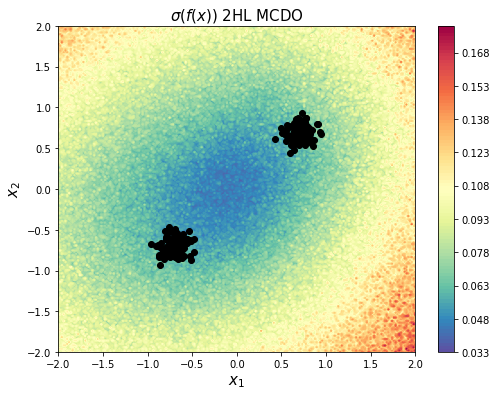

In [34]:
plot_res(xx,yy,std.reshape(200,200),
         '2HL MCDO',kind='2d',
         x_coords = x, y_coords = y)

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C

In [0]:
target_np = target.detach().numpy()
points_np = points.detach().numpy()

In [0]:
kernel = C(10, (1e-3, 1e3)) * Matern(1, (1e-1, 1e10),20)

In [0]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [39]:
gp.fit(points_np,target_np)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=3.16**2 * Matern(length_scale=1, nu=20),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [40]:
y_pred, sigma = gp.predict(grid.detach().numpy(), return_std=True)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [0]:
zz = sigma.reshape(200,200)

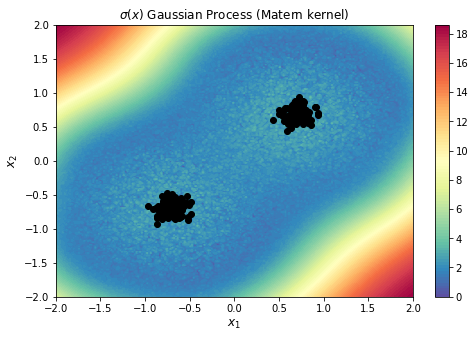

In [42]:
plt.figure(figsize=(8,5))
plt.contourf(xx, yy, zz, 100, cmap='Spectral_r')
plt.colorbar()
plt.scatter(x,y,color='black')
plt.title('$\sigma(x)$ Gaussian Process (Matern kernel)',fontsize=12)
plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12)
plt.savefig('$\sigma(x)$ Gaussian Process (Matern kernel)')
plt.show()

In [0]:
def var(x,gamma,x0=0):
  return 1/np.pi/gamma*(gamma**2/((x-x0)**2+gamma**2) )
gamma = 0.3

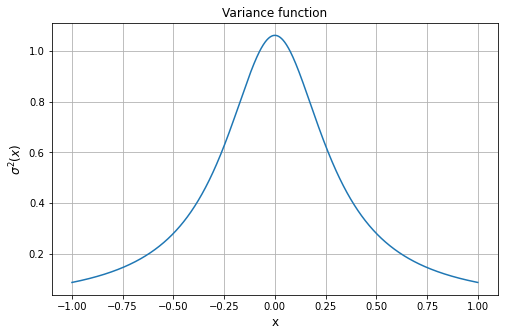

In [44]:
x_np = np.linspace(-1,1,1000)
x = torch.linspace(-1,1,1000)[:,None]

plt.figure(figsize=(8,5))
plt.plot(x,var(x,gamma))
plt.title('Variance function',fontsize=12)
plt.xlabel('x',fontsize=12)
plt.ylabel('$\sigma^2(x)$',fontsize=12)
plt.grid(True)
plt.savefig('Variance_function.jpeg')
plt.show()


In [0]:
from random import sample
def avg(x):
  return torch.sin(2*x) + 0.66*torch.cos(7*x) + torch.exp(x**2)

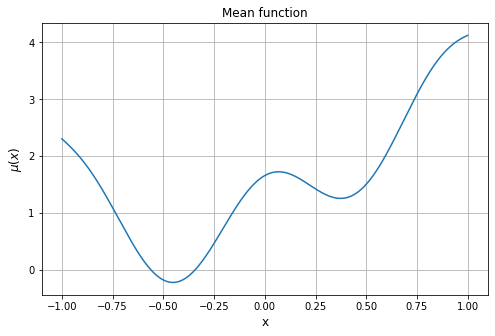

In [46]:
plt.figure(figsize=(8,5))
plt.plot(x,avg(x))
plt.title('Mean function',fontsize=12)
plt.xlabel('x',fontsize=12)
plt.ylabel('$\mu(x)$',fontsize=12)
plt.grid(True)
plt.savefig('Mean_function.jpeg')
plt.show()

In [0]:
mu_ =  avg(x)
var_ = var(x,gamma)

In [0]:
N_points = 40

In [0]:
inds = sorted(sample(list(range(1000)),N_points))

In [0]:
points = torch.Tensor(x_np[inds])[:,None]
mu_target = avg(points)
var_target = var(points,gamma)

In [0]:
n_epochs = 6000
n_layers = 1
f_bnn1 = Bayesian_ReLU(1, 2, n_layers).to(device)
f_optbnn1 = optim.Adam(f_bnn1.parameters(), lr=1e-3)

f_bnn1_var = Bayesian_ReLU(1, 2, n_layers).to(device)
f_optbnn1_var = optim.Adam(f_bnn1_var.parameters(), lr=1e-3)

f_mc1 = MCDO(1, 1, n_layers).to(device)
f_optmc1 = optim.Adam(f_mc1.parameters(), lr=1e-3)

In [0]:
train_model(f_bnn1,n_layers,f_optbnn1,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target,variance = 'constant')

In [0]:
mu,std = make_predictions(f_bnn1,x,variance = 'constant')
mu,std = mu.detach().numpy(),std.detach().numpy()

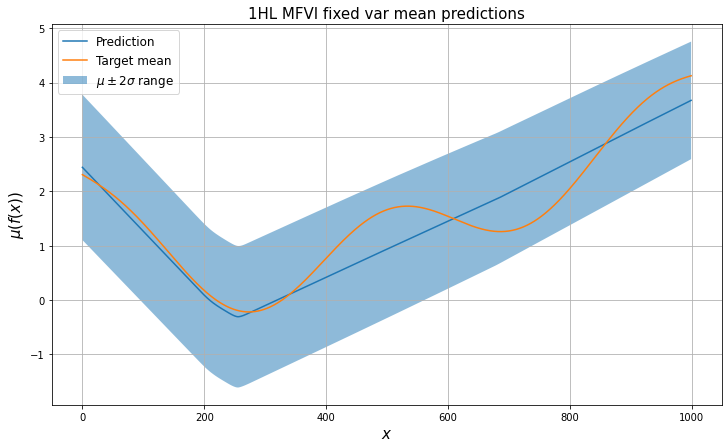

In [54]:
plot_res(mu_,std,mu,
         '1HL MFVI fixed var',kind='mean')

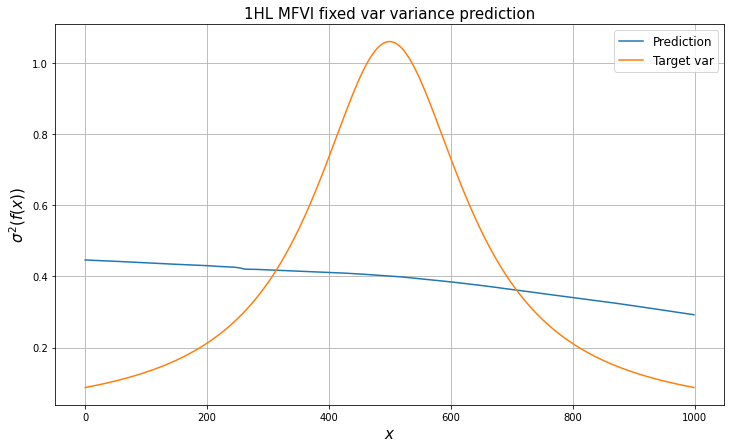

In [55]:
plot_res(var_,std,mu,
         '1HL MFVI fixed var',kind='var')

In [0]:
train_model(f_bnn1_var,n_layers,f_optbnn1_var,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target,variance = 'estimate')

In [0]:
mu,std = make_predictions(f_bnn1_var,x,variance = 'estimate')
mu,std = mu.detach().numpy(),std.detach().numpy()

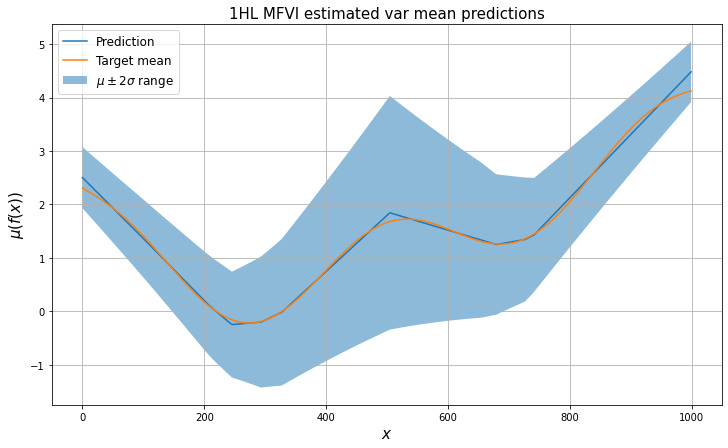

In [58]:
plot_res(mu_,std,mu,
         '1HL MFVI estimated var',kind='mean')

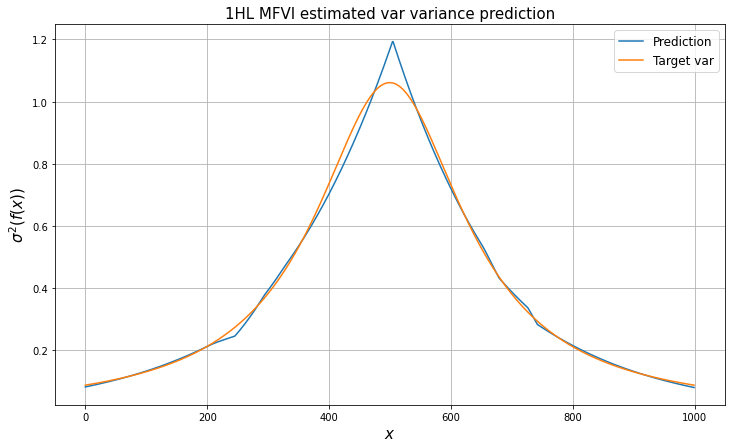

In [59]:
plot_res(var_,std,mu,
         '1HL MFVI estimated var',kind='var')

In [0]:
train_model(f_mc1,n_layers,f_optmc1,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target)

In [0]:
mu,std = make_predictions(f_mc1,x)
mu,std = mu.detach().numpy(),std.detach().numpy()

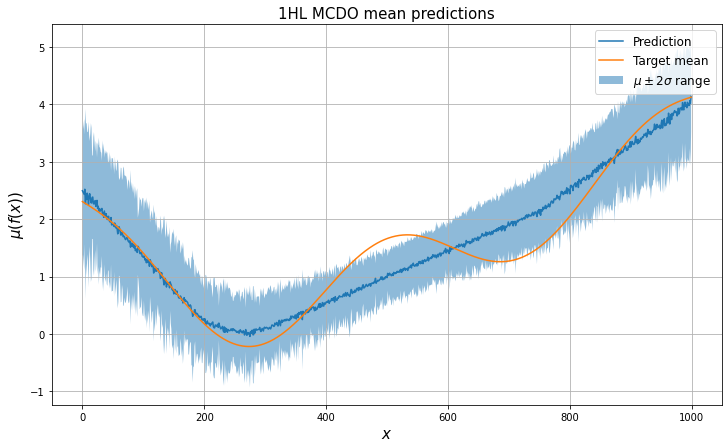

In [62]:
plot_res(mu_,std,mu,
         '1HL MCDO',kind='mean')

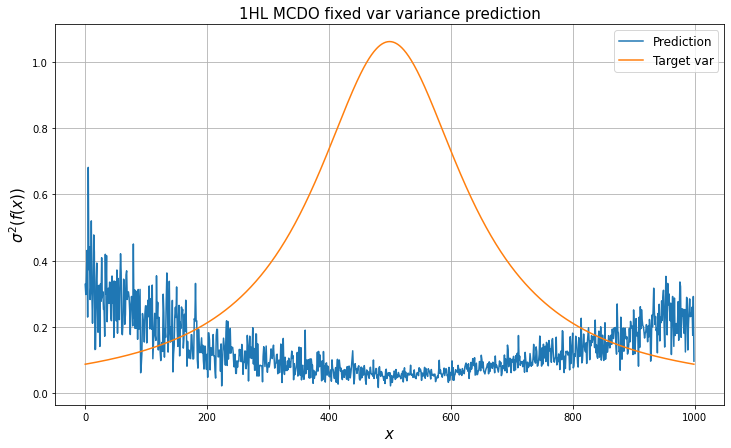

In [63]:
plot_res(var_,std,mu,
         '1HL MCDO fixed var',kind='var')

In [0]:
n_epochs = 6000
n_layers = 2
f_bnn2 = Bayesian_ReLU(1, 2, n_layers).to(device)
f_optbnn2 = optim.Adam(f_bnn2.parameters(), lr=1e-3)

f_bnn2_var = Bayesian_ReLU(1, 2, n_layers).to(device)
f_optbnn2_var = optim.Adam(f_bnn2_var.parameters(), lr=1e-3)

f_mc2 = MCDO(1, 1, n_layers).to(device)
f_optmc2 = optim.Adam(f_mc2.parameters(), lr=1e-3)

In [0]:
train_model(f_bnn2,n_layers,f_optbnn2,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target,variance = 'constant')

In [0]:
mu,std = make_predictions(f_bnn2,x,variance = 'constant')
mu,std = mu.detach().numpy(),std.detach().numpy()

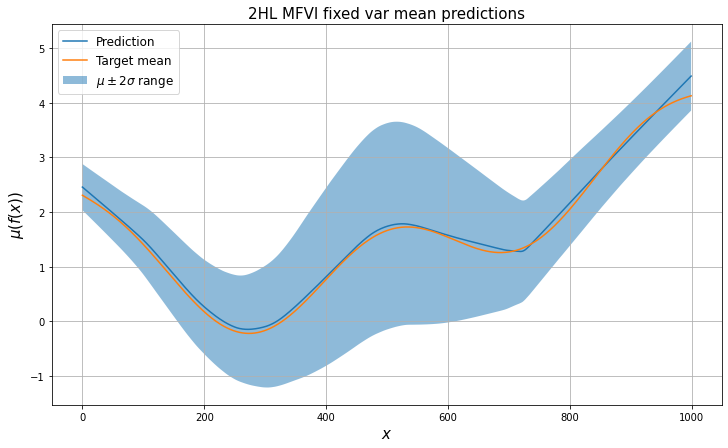

In [67]:
plot_res(mu_,std,mu,
         '2HL MFVI fixed var',kind='mean')

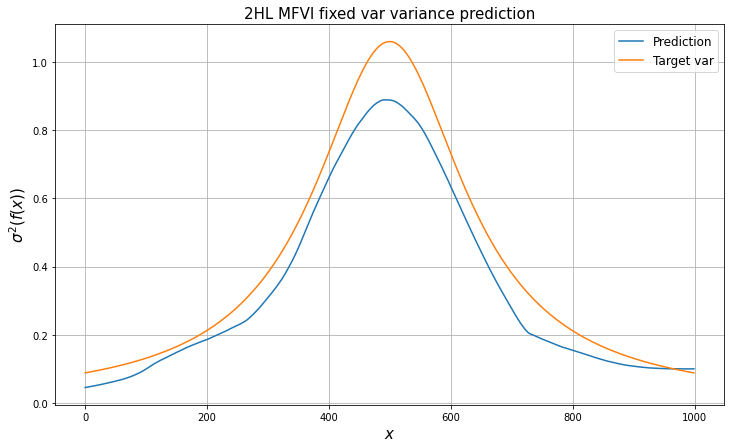

In [68]:
plot_res(var_,std,mu,
         '2HL MFVI fixed var',kind='var')

In [0]:
train_model(f_bnn2_var,n_layers,f_optbnn2_var,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target,variance = 'estimate')

In [0]:
mu,std = make_predictions(f_bnn2_var,x,variance = 'estimate')
mu,std = mu.detach().numpy(),std.detach().numpy()

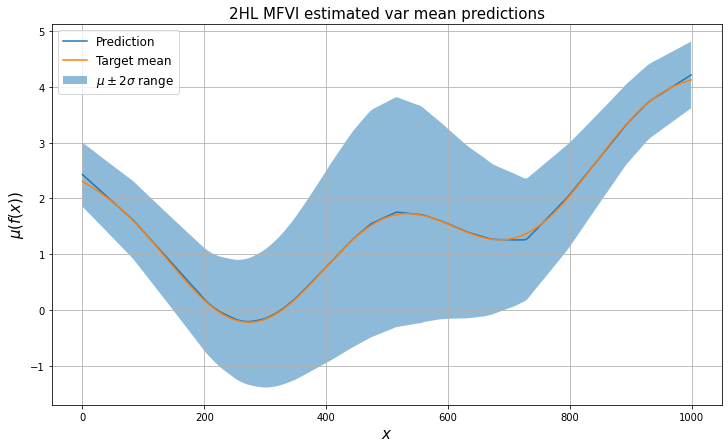

In [71]:
plot_res(mu_,std,mu,
         '2HL MFVI estimated var',kind='mean')

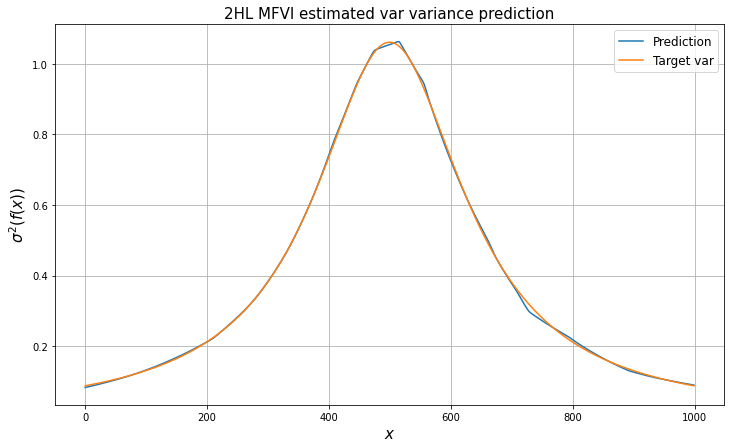

In [72]:
plot_res(var_,std,mu,
         '2HL MFVI estimated var',kind='var')

In [0]:
train_model(f_mc2,n_layers,f_optmc2,loss_vi,
          n_epochs,TRAIN_LENGTH,points, mu_target,var_target)

In [0]:
mu,std = make_predictions(f_mc2,x)
mu,std = mu.detach().numpy(),std.detach().numpy()

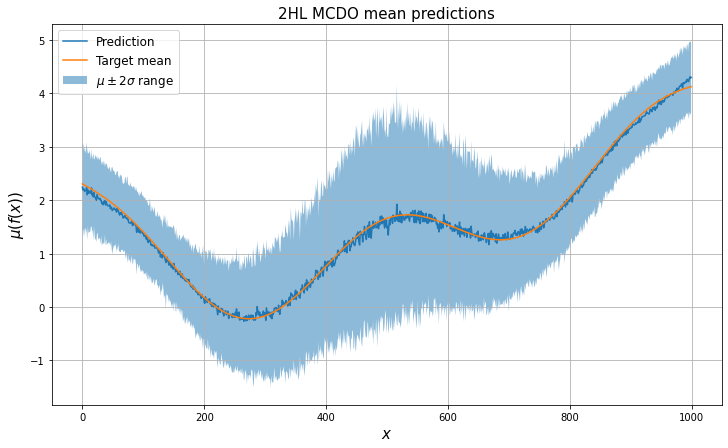

In [75]:
plot_res(mu_,std,mu,
         '2HL MCDO',kind='mean')

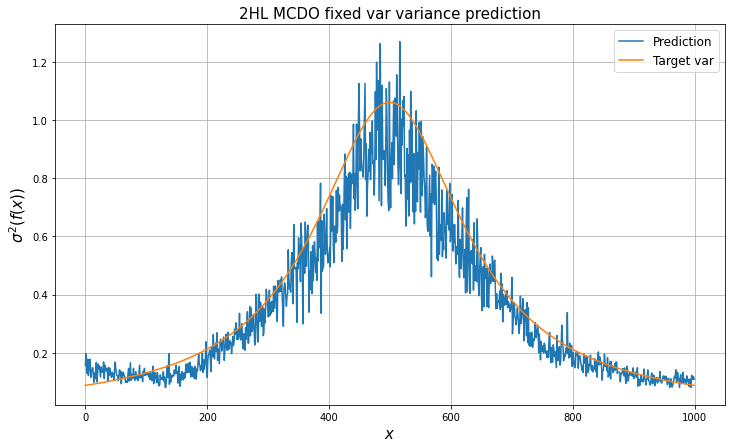

In [76]:
plot_res(var_,std,mu,
         '2HL MCDO fixed var',kind='var')